# Sixt Data Science Lab - Test Task for Data Scientist Job Candidates

## Import

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1 - Data Loading and Environment Preparation

**Tasks:**
1. Prepare a Python 3 virtual environment (with virtualenv command). requirements.txt output of pip freeze command should be included as part of your submission.
2. Load the data from UCI Repository and put it into the same folder with the notebook. The link to it is https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset . Here is an available mirror in case the above website is down: https://data.world/uci/bike-sharing-dataset
3. We split the data into two parts. One dataset containing the last 30 days and one dataset with the rest.

In [2]:
# read raw data
df_all = pd.read_csv('./data/day.csv')

# split dataset
df_last30 = df_all.tail(30)
df = df_all.iloc[:-30, :]

df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
df.shape

(701, 16)

## Part 2 - Data Processing and Analysis

**Tasks:**
1. Perform all needed steps to load and clean the data. Please comment the major steps of your code.
2. Visualise rentals of bikes per day.
3. Assume that each bike has exactly maximum 12 rentals per day.
    * Find the maximum number of bicycles `nmax` that was needed in any one day.
    * Find the 95%-percentile of bicycles `n95` that was needed in any one day.
5. Visualize the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)


### 2.1 Clean Data

In [4]:
# Drop unnecessary columns
df = df.drop(['dteday','instant', 'yr'], axis=1)

In [5]:
# Missing Values?
print(f"Missing Values: {df.isnull().sum()}")

Missing Values: season        0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [6]:
# Duplicate Values?
print(f"Duplicated Values: {df.duplicated().sum()}")

Duplicated Values: 0


In [7]:
# Wrong Data Types?
print(f"Data typs: {df.dtypes}")

Data typs: season          int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


In [8]:
df['holiday'] = df['holiday'].astype('category')
df['workingday'] = df['workingday'].astype('category')

In [9]:
df["weekday"] = df["weekday"].replace({0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'})
df["weathersit"] = df["weathersit"].replace({1: 'Clear', 2: 'Misty', 3: 'Light_rainsnow', 4: 'Heavy_rainsnow'})
df["mnth"] = df["mnth"].replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
df['season'] = df['season'].replace({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})


In [10]:
# Outliers
def check_outliers(df):
    columns = ['temp', 'atemp', 'hum', 'windspeed']
    outliers = {}
    
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers


In [11]:
outliers = check_outliers(df)

In [12]:
for key, value in outliers.items():
    print(f"Outliers for {key}: {value.shape[0]}")

Outliers for temp: 0
Outliers for atemp: 0
Outliers for hum: 2
Outliers for windspeed: 12


In [13]:
outliers['windspeed']

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
44,spring,Feb,0,Monday,1,Clear,0.415000,0.398350,0.375833,0.417908,208,1705,1913
49,spring,Feb,0,Saturday,0,Clear,0.399167,0.391404,0.187917,0.507463,532,1103,1635
93,summer,Apr,0,Monday,1,Clear,0.573333,0.542929,0.426250,0.385571,734,2381,3115
94,summer,Apr,0,Tuesday,1,Misty,0.414167,0.398350,0.642083,0.388067,167,1628,1795
292,winter,Oct,0,Thursday,1,Clear,0.475833,0.466525,0.636250,0.422275,471,3724,4195
382,spring,Jan,0,Wednesday,1,Clear,0.303333,0.275254,0.443333,0.415429,109,3267,3376
407,spring,Feb,0,Sunday,0,Clear,0.127500,0.101658,0.464583,0.409212,73,1456,1529
420,spring,Feb,0,Saturday,0,Clear,0.290833,0.255675,0.395833,0.421642,317,2415,2732
432,spring,Mar,0,Thursday,1,Clear,0.527500,0.524604,0.567500,0.441563,486,4896,5382
433,spring,Mar,0,Friday,1,Misty,0.410833,0.397083,0.407083,0.414800,447,4122,4569


**Handle Outlier**

1. *Delete Samples with Outliers*
2. Insert Values
    - Numerical Columns:
        - **Threshold**: Replaces clipped values with the specified threshold value.
        - **Mean**: Replaces clipped values with the mean of the column values. The mean is computed before values are clipped.
        - **Median**: Replaces clipped values with the median of the column values. The median is computed before values are clipped. More solid as Mean because of outlier
        - **Missing**. Replaces clipped values with the missing (empty) value.
    - Categorical Columns:
        - Imputing a category like “Other” might be more reasonable, because in such a case, your imputation is likely to converge a random selection.
3. Keep them
4. Binning 
    - The main motivation of binning is to make the model more robust and prevent overfitting, however, it has a cost to the performance.

In [14]:
# because most of them have weathersit = 1 (Clear, Few clouds, Partly cloudy, Partly cloudy), it is reasonable to remove them
df = df.drop(outliers['windspeed'].index)
df.shape

(689, 13)

### 2.2 Visualise rentals of bikes per day.

Text(0.5, 1.0, 'Distribution of bike rentals each day of the week')

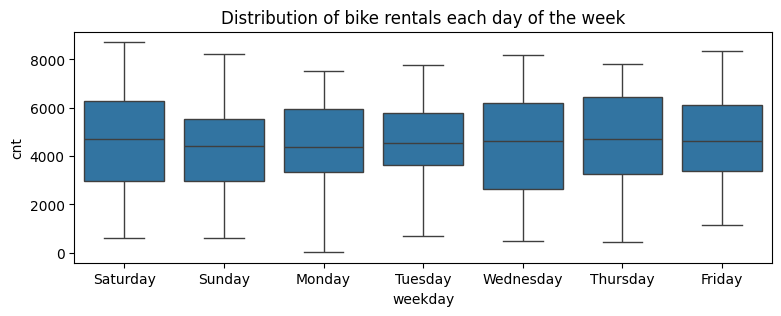

In [15]:
plt.figure(figsize=(9,3))
sns.boxplot(x='weekday', y='cnt', data=df)
plt.title('Distribution of bike rentals each day of the week')

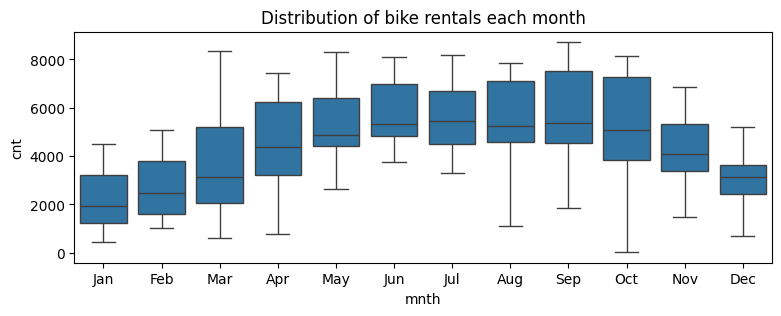

In [16]:
plt.figure(figsize=(9,3))
sns.boxplot(x='mnth', y='cnt', data=df)
plt.title('Distribution of bike rentals each month')
plt.show()

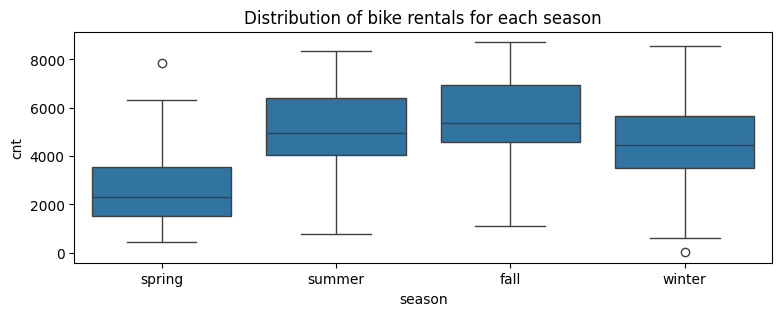

In [17]:
plt.figure(figsize=(9,3))
sns.boxplot(x='season', y='cnt', data=df)
plt.title('Distribution of bike rentals for each season')
plt.show()

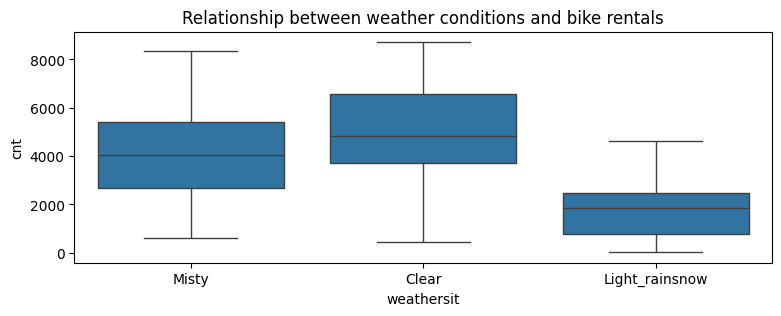

In [18]:
plt.figure(figsize=(9,3))
sns.boxplot(x='weathersit', y='cnt', data=df)
plt.title('Relationship between weather conditions and bike rentals')
plt.show()

### 2.3 Assume that each bike has exactly maximum 12 rentals per day.
Find the maximum number of bicycles `nmax` that was needed in any one day.

In [19]:
nmax = df['cnt'].max() // 12
nmax

726

Find the 95%-percentile of bicycles `n95` that was needed in any one day.

In [20]:
n95 = np.percentile(df['cnt'], 95) // 12
n95

632.0

### 2.5 Visualize the distribution of the covered days depending on the number of available bicycles

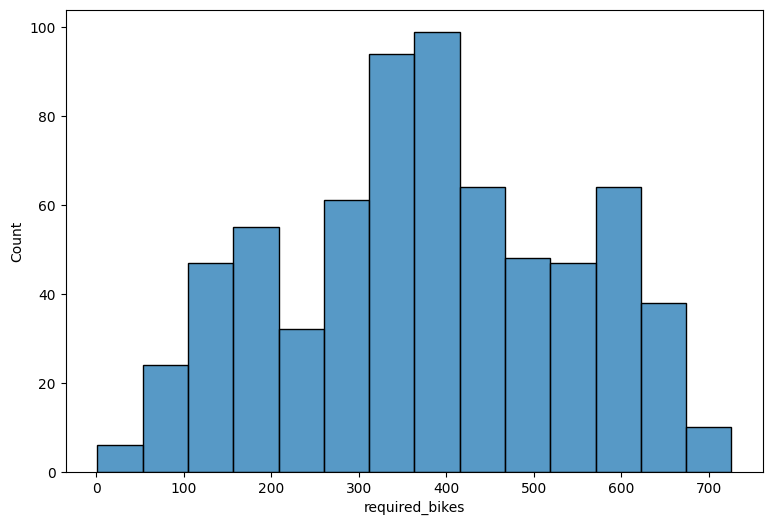

In [21]:
df['required_bikes'] = df['cnt'] // 12
plt.figure(figsize=(9, 6))
sns.histplot(data=df, x='required_bikes', edgecolor='black')
plt.show()

In [22]:
bike_per_percentiles = []
coverage_days_in_percent = []
for i in range(0, 105, 5):
    nb_bikes = np.percentile(df['cnt'], i) // 12
    coverage_days = df[df['cnt'] < nb_bikes].shape[0]
    total_days = df.shape[0]
    bike_per_percentiles.append(nb_bikes)
    coverage_days_in_percent.append(coverage_days / total_days * 100)

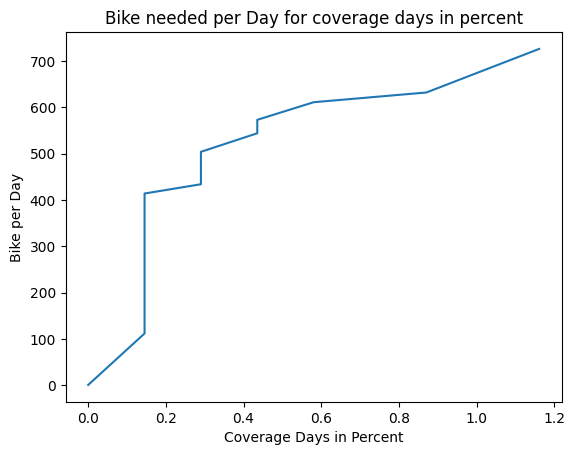

In [23]:
plt.plot(coverage_days_in_percent, bike_per_percentiles)
plt.xlabel('Coverage Days in Percent')
plt.ylabel('Bike per Day')
plt.title('Bike needed per Day for coverage days in percent')
plt.show()


**Answers / comments / reasoning:**
- I would draw the department's attention to the fact that the static number of max. 12 rentals per bike per day might be an oversimplification and that designing the fleet to this number could lead to unused resources.  
- How often a bike is rented probably depends to a large extent on the location of the station and weekday vs. weekend. 

## Part 3 - Building prediction models

**Tasks:**
1. Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.
2. Build a demand prediction model with Random Forest, preferably making use of following python libraries: scikit-learn. 
3. Report the value of the chosen test metric on the provided data. 

### 3.0 Feature Engineering

In [24]:
# Encoding Categorical Data
# Random Forest, does not inherently require one-hot encoding for categorical data that is already numerically encoded.
# For nominal data, where there is no inherent order, using numerical encoding can inadvertently introduce an artificial 
# order or distance that the model might misconstrue as meaningful.
df = pd.get_dummies(df, columns=['season', 'weathersit', 'weekday', 'mnth', 'holiday', 'workingday'], dtype=int)
df.head()

,temp,atemp,hum,windspeed,casual,registered,cnt,required_bikes,season_fall,season_spring,...,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,holiday_0,holiday_1,workingday_0,workingday_1
0,0.344167,0.363625,0.805833,0.160446,331,654,985,82,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0.363478,0.353739,0.696087,0.248539,131,670,801,66,0,1,...,0,0,0,0,0,0,1,0,1,0
2,0.196364,0.189405,0.437273,0.248309,120,1229,1349,112,0,1,...,0,0,0,0,0,0,1,0,0,1
3,0.200000,0.212122,0.590435,0.160296,108,1454,1562,130,0,1,...,0,0,0,0,0,0,1,0,0,1
4,0.226957,0.229270,0.436957,0.186900,82,1518,1600,133,0,1,...,0,0,0,0,0,0,1,0,0,1


### 3.1 Define a test metric

Those metrics are available for regression tasks:
- Mean Absolute Error (MAE): MAE is easy to understand and interpret but doesn't penalize large errors.
- Mean Squared Error (MSE): MSE penalizes larger errors more heavily than smaller ones, which can be useful if it's particularly important to avoid large errors in the bike rental predictions.
- Root Mean Squared Error (RMSE): It has the advantage of being in the same units as the target variable, making it easier to interpret than MSE.
- R-squared (R²): While it's widely used for assessing the goodness of fit in linear regression models, it can be misleading if used alone for model selection, as it always increases with more predictors.
- Mean Absolute Percentage Error (MAPE): It’s useful for understanding the magnitude of prediction errors in terms of percentage, which can be very intuitive for stakeholders.
- Adjusted R-squared: It's useful when comparing models with a different number of predictors, penalizing the addition of irrelevant predictors to the model.

Given this task, I would choos the RMSE, because it:
- Is in the same units as the target variable, making interpretation straightforward
- Penalizes larger errors more heavily than smaller ones
- Offers a clear indication of model performance; lower values signify better performance, and improvements in RMSE are directly correlated with improvements in the accuracy of the model's predictions.

### 3.2 Demand prediction model with a random forest model

In [25]:
#creating dimensions for Modelling
x_data = df.drop(['cnt', 'casual', 'registered'], axis=1)
y_data = df['cnt']

In [26]:
# First, split the data into training (80%) and the remaining (20%)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
print("shape of X_train",X_train.shape)
print("shape of y_train",y_train.shape)
print("shape of X_test",X_test.shape)
print("shape of y_test",y_test.shape)

shape of X_train (551, 35)
shape of y_train (551,)
shape of X_test (138, 35)
shape of y_test (138,)


In [27]:
# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a random forest regressor
rf = RandomForestRegressor()

# Create the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train a random forest model with the best parameters
best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=10)

In [28]:
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### 3.3 Evaluation

In [29]:
# Predict the target variable using the trained model
y_pred = best_rf.predict(X_test)

# Calculate the RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print(f"The RMSE is: {round(rmse, 2)}")

The RMSE is: 50.84


An RMSE of 50 means that, on average, the model's predictions are 51 units away from the actual values.

In [30]:
# What are the top 5 deviations?
y_pred = pd.Series(y_pred).reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
deviation = y_test - y_pred
top_5_deviation = deviation.abs().nlargest(5)
y_test_top5 = y_test[top_5_deviation.index]
y_pred_top5 = y_pred[top_5_deviation.index]
difference_top5 = deviation[top_5_deviation.index]


In [31]:
data = {'actual_cnt': y_test_top5, 'predicted_cnt': y_pred_top5, 'difference': difference_top5}
df_deviation = pd.DataFrame(data)
print(df_deviation)

     actual_cnt  predicted_cnt  difference
1            22     582.290000 -560.290000
101        2566    2472.519778   93.480222
29          705     616.380000   88.620000
21         2594    2649.950000  -55.950000
129        1746    1703.390000   42.610000


In [32]:
df[df['cnt'].isin([22])]

,temp,atemp,hum,windspeed,casual,registered,cnt,required_bikes,season_fall,season_spring,...,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,holiday_0,holiday_1,workingday_0,workingday_1
667,0.44,0.4394,0.88,0.3582,2,20,22,1,0,0,...,0,0,0,0,1,0,1,0,0,1


What was on the 29.10.2019 in Washington DC? --> "Washington DC shuts down in preparation for hurricane ..."

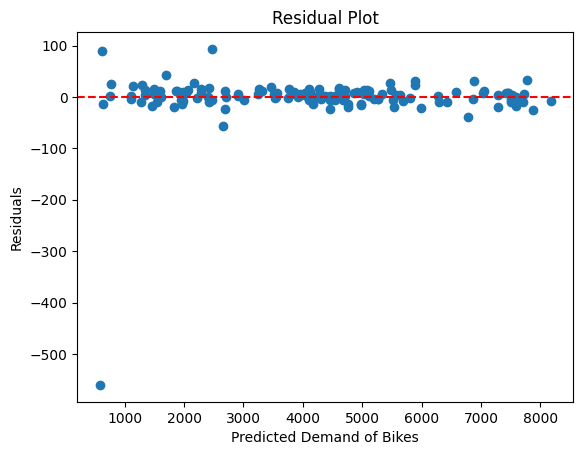

In [33]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Demand of Bikes')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


A residual plot is another valuable diagnostic tool in regression analysis. It helps to visualize the difference between the observed values and the values predicted by the model, known as the residuals. The residuals are plotted against the predicted values or the independent variables. A good regression model will show residuals randomly scattered around the horizontal axis (y = 0). If there are patterns or trends in the plot, they may indicate that the model has not captured some underlying structure in the data.

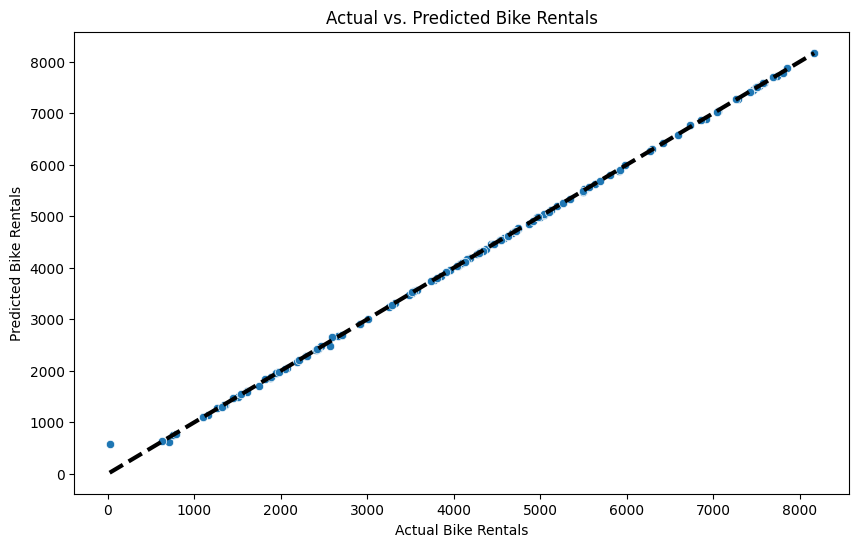

In [34]:
# Scatter Plot of Actual vs. Predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Ideal prediction line
plt.xlabel('Actual Bike Rentals')
plt.ylabel('Predicted Bike Rentals')
plt.title('Actual vs. Predicted Bike Rentals')
plt.show()

This scatter plot compares the actual bike rentals with the predicted bike rentals. The closer the points are to a straight line, the better the model’s predictions.

**Answers / comments / reasoning:**

1. Normaly, I would try different approaches:
    1. Rather than picking the favorite algorithm, try several algorithms
    2. Then, I would double down on those that show signs of being better in performance, robustness, speed or whatever is important
2. The Goal at this stage is to achieve statistical power (develop a model that is capable of beating a random choice. But this is not always possible to achieve. If I can’t beat a random baseline, it may be that the answer to the question is not present in the input data.
3. Once I have obtained a model that has statistical power, the question is: Is the model sufficiently powerful?
4. If the model performance is bad, I would test the ML model with a classic data set of the problem area (regression, classification, ...) to check whether the programmed model is basically good and the data is bad or there is an error in the code

## Part 4 - Reflection / comments

Very cool Data Science Challange. In addition to pure methodology, I think it is extremely important to test the software engineering skills of data scientists. Of course, whether a data-driven software project is successful or not also depends on other influencing factors such as data quality, stability of the process that should be automated, etc. However, how well I can test my software, make adjustments to the code due to changing business conditions or react to architectural adjustments is often dependent on good software engineering. And a data scientist must have this skill!

## Submission

Please submit this notebook with your developments in .ipynb and .html formats as well as your requirements.txt file.

## References

[1] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.